In [1]:
!pip install -q -U umap-learn 



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from typing import List, Tuple
from dataclasses import dataclass

from xformers.ops.fmha.attn_bias import (
    AttentionBias,
    BlockDiagonalCausalMask,
    BlockDiagonalCausalWithOffsetPaddedKeysMask,
    BlockDiagonalMask,
)


@dataclass
class RotatingCacheInputMetadata:
    # rope absolute positions
    positions: torch.Tensor
    # which elements in the sequences need to be cached
    to_cache_mask: torch.Tensor
    # how many elements are cached per sequence
    cached_elements: torch.Tensor
    # where tokens should go in the cache
    cache_positions: torch.Tensor

    # if prefill, use block diagonal causal mask
    # else use causal with padded key mask
    prefill: bool
    mask: AttentionBias
    seqlens: List[int]


def interleave_list(l1: List[torch.Tensor], l2: List[torch.Tensor]):
    assert len(l1) == len(l2)
    return [v for pair in zip(l1, l2) for v in pair]


def unrotate(cache: torch.Tensor, seqlen: int) -> torch.Tensor:
    assert cache.ndim == 3  # (W, H, D)
    position = seqlen % cache.shape[0]
    if seqlen < cache.shape[0]:
        return cache[:seqlen]
    elif position == 0:
        return cache
    else:
        return torch.cat([cache[position:], cache[:position]], dim=0)


class CacheView:
    def __init__(self, cache_k: torch.Tensor, cache_v: torch.Tensor, metadata: RotatingCacheInputMetadata, kv_seqlens: torch.Tensor):
        self.cache_k = cache_k
        self.cache_v = cache_v
        self.kv_seqlens = kv_seqlens
        self.metadata = metadata

    def update(self, xk: torch.Tensor, xv: torch.Tensor):
        """
        to_cache_mask masks the last [sliding_window] tokens in each sequence
        """
        n_kv_heads, head_dim = self.cache_k.shape[-2:]
        flat_cache_k = self.cache_k.view(-1, n_kv_heads, head_dim)
        flat_cache_v = self.cache_v.view(-1, n_kv_heads, head_dim)
        
        flat_cache_k.index_copy_(0, self.metadata.cache_positions, xk[self.metadata.to_cache_mask])
        flat_cache_v.index_copy_(0, self.metadata.cache_positions, xv[self.metadata.to_cache_mask])

    def interleave_kv(self, xk: torch.Tensor, xv: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        This is a naive implementation and not optimized for speed.
        """
        assert xk.ndim == xv.ndim == 3 # (B * T, H, D)
        assert xk.shape == xv.shape

        if all([s == 0 for s in self.metadata.seqlens]):
            # No cache to interleave
            return xk, xv

        # Make it a list of [(T, H, D)]
        xk = torch.split(xk, self.metadata.seqlens)
        xv = torch.split(xv, self.metadata.seqlens)
        assert len(xk) == len(self.kv_seqlens), f"Batch size is {len(self.kv_seqlens)}, got {len(xk)}"

        # Order elements in cache by position by unrotating
        cache_k = [unrotate(t, s) for t, s in zip(self.cache_k, self.kv_seqlens)]
        cache_v = [unrotate(t, s) for t, s in zip(self.cache_v, self.kv_seqlens)]

        interleaved_k = interleave_list(cache_k, xk)
        interleaved_v = interleave_list(cache_v, xv)

        return torch.cat(interleaved_k, dim=0), torch.cat(interleaved_v, dim=0)

    @property
    def sliding_window(self):
        return self.cache_k.shape[1]

    @property
    def key(self) -> torch.Tensor:
        return self.cache_k[:len(self.kv_seqlens)]

    @property
    def value(self) -> torch.Tensor:
        return self.cache_v[:len(self.kv_seqlens)]

    @property
    def prefill(self):
        return self.metadata.prefill

    @property
    def mask(self):
        return self.metadata.mask


class RotatingBufferCache:
    """
    This is an example that implements a less naive rotating buffer cache, allowing for variable length sequences.
    Allocated cache is rectangular which is wasteful (see PagedAttention for better mechanisms)
    """
    def __init__(self, n_layers: int, max_batch_size: int, sliding_window: int, n_kv_heads: int, head_dim: int):

        self.sliding_window = sliding_window
        self.n_kv_heads = n_kv_heads
        self.head_dim = head_dim

        self.cache_k = torch.empty((
            n_layers,
            max_batch_size,
            sliding_window,
            n_kv_heads,
            head_dim
        ))
        self.cache_v = torch.empty((
            n_layers,
            max_batch_size,
            sliding_window,
            n_kv_heads,
            head_dim
        ))
        # holds the valid length for each batch element in the cache
        self.kv_seqlens = None

    def get_view(self, layer_id: int, metadata: RotatingCacheInputMetadata) -> CacheView:
        return CacheView(self.cache_k[layer_id], self.cache_v[layer_id], metadata, self.kv_seqlens)

    def reset(self):
        self.kv_seqlens = None

    def init_kvseqlens(self, batch_size: int):
        self.kv_seqlens = torch.zeros((batch_size,), device=self.device, dtype=torch.long)

    @property
    def device(self):
        return self.cache_k.device

    def to(self, device: torch.device, dtype: torch.dtype):
        self.cache_k = self.cache_k.to(device=device, dtype=dtype)
        self.cache_v = self.cache_v.to(device=device, dtype=dtype)

        return self

    def update_seqlens(self, seqlens: List[int]):
        self.kv_seqlens += torch.tensor(seqlens, device=self.device, dtype=torch.long)

    def get_input_metadata(self, seqlens: List[int]) -> RotatingCacheInputMetadata:
        """
            inpput = seqlens [5,7,2] // seqpos [0, 1, 3] // sliding_window 3
            --> only cache last 3 tokens in each sequence
            - to_cache_mask = [0 0 1 1 1 | 0 0 0 0 1 1 1 | 1 1]
            - cached_elements = [3 | 3 | 2]
            --> absolute positions are used for rope
            - positions = [0 1 2 3 4 | 1 2 3 4 5 6 7 | 3 4]
            --> cache positions are positions cache_masked, modulo sliding_window + batch_idx * sliding_window
            - cache_positions = [2 0 1 | 5 3 4 | 6 7]
        """
        if self.kv_seqlens is None:
            self.init_kvseqlens(len(seqlens))
        assert len(seqlens) == len(self.kv_seqlens), f"Batch size is {len(self.kv_seqlens)}, got {len(seqlens)}, did you forget to reset cache?"
        seqpos = self.kv_seqlens.tolist()

        assert len(seqlens) > 0, seqlens
        masks = [
            [x >= seqlen - self.sliding_window for x in range(seqlen)]
            for seqlen in seqlens
        ]
        to_cache_mask = torch.tensor(sum(masks, []), device=self.device, dtype=torch.bool)
        cached_elements = torch.tensor([sum(mask) for mask in masks], device=self.device, dtype=torch.long)
        positions = torch.cat([torch.arange(pos, pos + seqlen) for pos, seqlen in zip(seqpos, seqlens)]).to(device=self.device, dtype=torch.long)
        batch_idx = torch.tensor(sum([[i]*seqlen for i, seqlen in enumerate(seqlens)], []), device=self.device, dtype=torch.long)
        cache_positions = positions % self.sliding_window + batch_idx * self.sliding_window

        first_prefill = seqpos[0] == 0
        subsequent_prefill = any(seqlen > 1 for seqlen in seqlens)
        if first_prefill:
            assert all([pos == 0 for pos in seqpos]), (seqpos)
            mask = BlockDiagonalCausalMask.from_seqlens(seqlens).make_local_attention(self.sliding_window)
        elif subsequent_prefill:
            mask = BlockDiagonalMask.from_seqlens(
                q_seqlen=seqlens,
                kv_seqlen=[s + cached_s.clamp(max=self.sliding_window).item() for (s, cached_s) in zip(seqlens, self.kv_seqlens)]
            ).make_local_attention_from_bottomright(self.sliding_window)
        else:
            mask = BlockDiagonalCausalWithOffsetPaddedKeysMask.from_seqlens(
                q_seqlen=seqlens,
                kv_padding=self.sliding_window,
                kv_seqlen=(self.kv_seqlens + cached_elements).clamp(max=self.sliding_window).tolist()
            )

        return RotatingCacheInputMetadata(
            positions=positions,
            to_cache_mask=to_cache_mask,
            cached_elements=cached_elements,
            cache_positions=cache_positions[to_cache_mask],
            prefill=first_prefill or subsequent_prefill,
            mask=mask,
            seqlens=seqlens,
        )


c:\Users\heman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


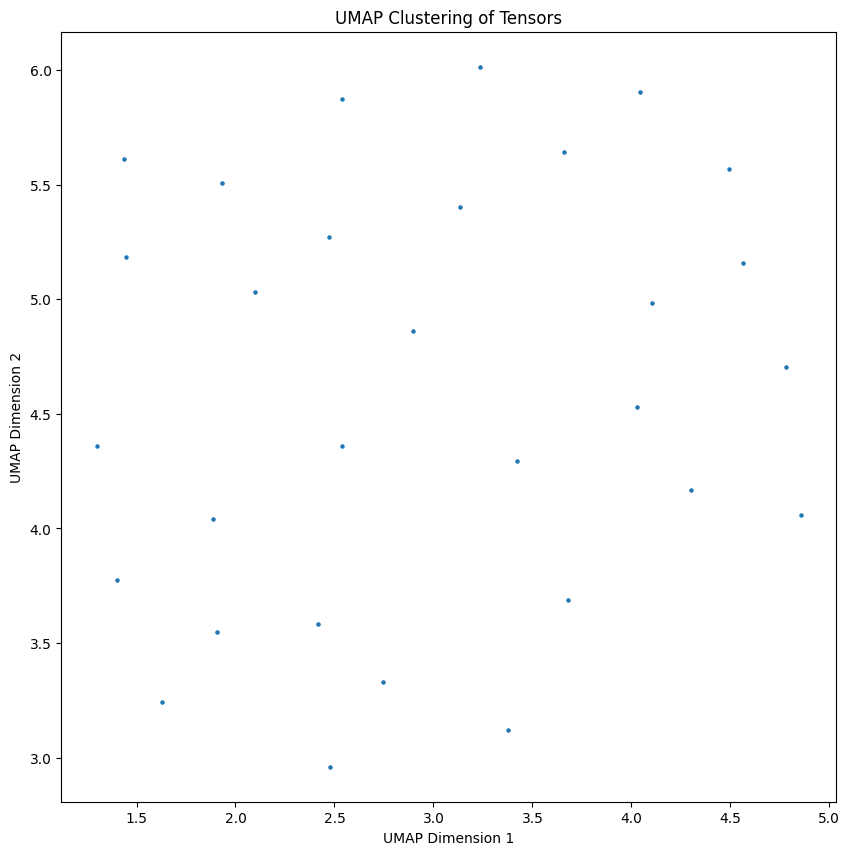

In [2]:
import torch
import umap
import matplotlib.pyplot as plt
from typing import List

def flatten_and_concatenate_tensors(tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Flatten each tensor in the list to 1D, and then concatenate them into a 2D tensor.

    Args:
        tensors (List[torch.Tensor]): A list of tensors of any shape.

    Returns:
        torch.Tensor: A 2D tensor with each row representing a flattened tensor.
    """
    flattened_tensors = [t.view(t.size(0), -1) for t in tensors]
    concatenated_data = torch.cat(flattened_tensors, dim=0)
    return concatenated_data

def visualize_tensor_clustering(tensors: List[torch.Tensor], n_neighbors: int = 15, min_dist: float = 0.1) -> None:
    """
    Visualize the clustering of tensors using UMAP.

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_neighbors (int): The number of neighbors to consider for each point in UMAP. Default is 15.
        min_dist (float): The minimum distance between points in the UMAP embedding space. Default is 0.1.

    Returns:
        None
    """
    # Flatten and concatenate the tensors into a single tensor
    data = flatten_and_concatenate_tensors(tensors)

    # Perform UMAP dimensionality reduction
    umap_data = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist).fit_transform(data.numpy())

    # Plot the UMAP embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(umap_data[:, 0], umap_data[:, 1], s=5)
    plt.title("UMAP Clustering of Tensors")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

# Example usage
tensor1 = torch.randn( 10, 10)
tensor2 = torch.randn( 10, 10)
tensor3 = torch.randn( 10, 10)


tensor_list = [tensor1, tensor2, tensor3]
visualize_tensor_clustering(tensor_list)


c:\Users\heman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


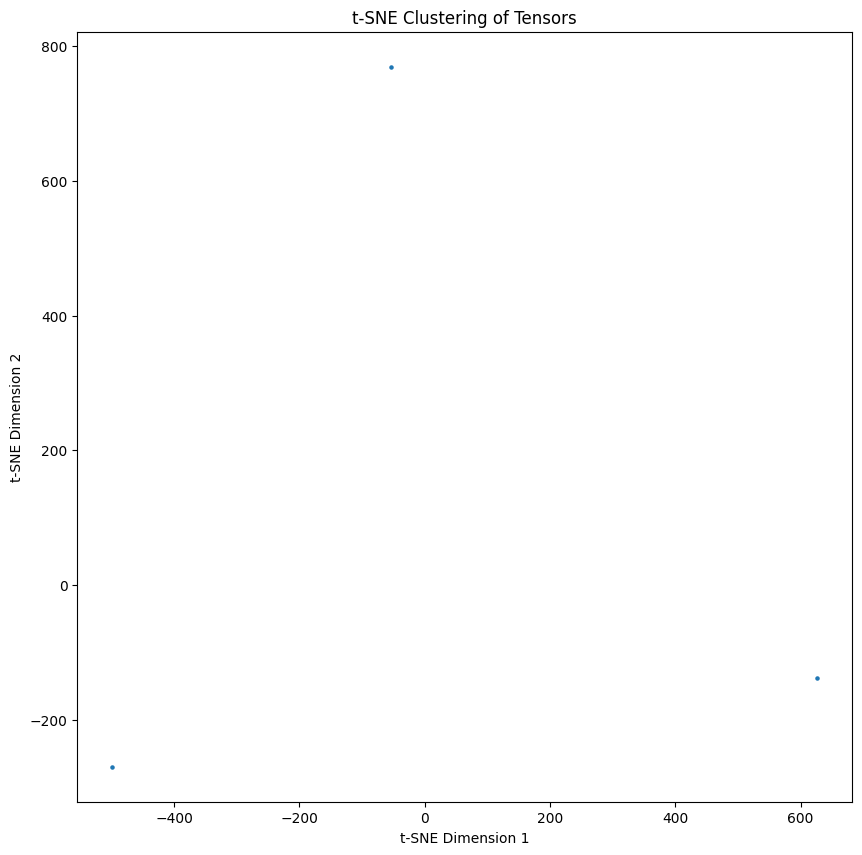

In [3]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from typing import List


def flatten_and_concatenate_tensors(tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Flatten each tensor in the list to 1D, and then concatenate them into a 2D tensor.

    Args:
        tensors (List[torch.Tensor]): A list of tensors of any shape.

    Returns:
        torch.Tensor: A 2D tensor with each row representing a flattened tensor.
    """
    # Flatten each tensor to 2D where the first dimension is the batch size
    flattened_tensors = [t.view(-1) for t in tensors]  # Flatten each tensor to 1D
    concatenated_data = torch.stack(flattened_tensors)  # Stack the 1D tensors into a 2D tensor
    return concatenated_data

def visualize_tensor_clustering(tensors: List[torch.Tensor], perplexity: float = None, learning_rate: float = 200.0, n_iter: int = 1000) -> None:
    """
    Visualize the clustering of tensors using t-SNE.

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        perplexity (float): The perplexity parameter for t-SNE. If None, it will be set to min(30, n_samples - 1).
        learning_rate (float): The learning rate for t-SNE optimization. Default is 200.0.
        n_iter (int): The number of iterations for t-SNE optimization. Default is 1000.

    Returns:
        None
    """
    # Flatten and concatenate the tensors into a single tensor
    data = flatten_and_concatenate_tensors(tensors)

    # Set the perplexity to a default value if it's not provided
    if perplexity is None:
        perplexity = min(30, data.size(0) - 1)

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_data = tsne.fit_transform(data.numpy())

    # Plot the t-SNE embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=5)
    plt.title("t-SNE Clustering of Tensors")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Example usage with the corrected function
tensor1 = torch.randn(10, )
tensor2 = torch.randn(10, )
tensor3 = torch.randn(10, )

tensor_list = [tensor1, tensor2, tensor3]
visualize_tensor_clustering(tensor_list)



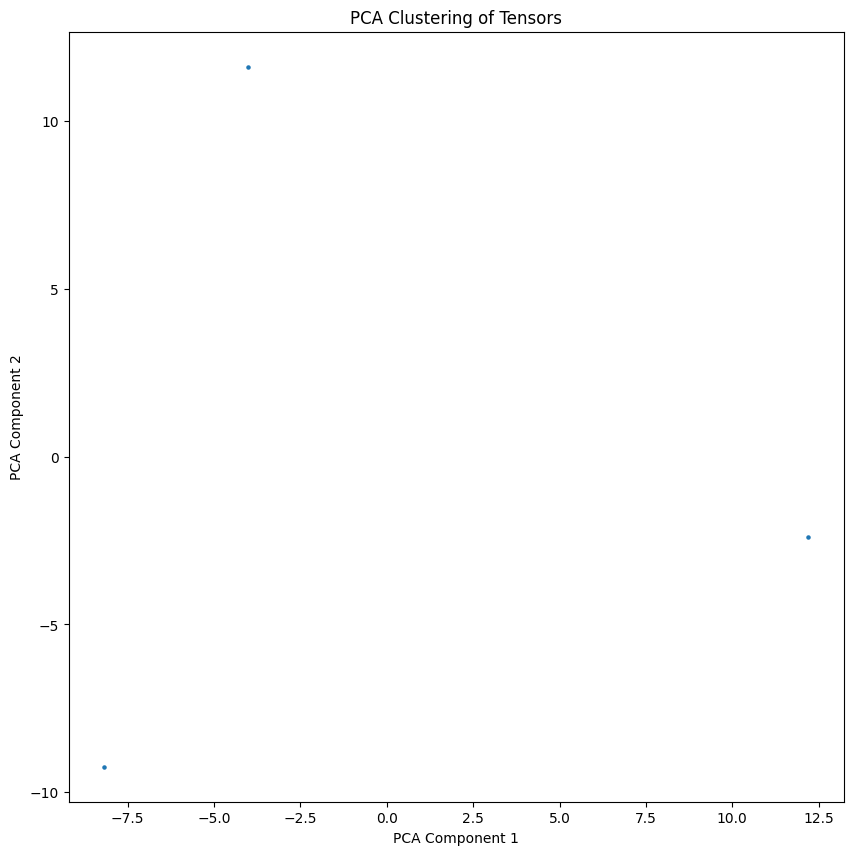

In [4]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from typing import List


def flatten_and_concatenate_tensors(tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Flatten each tensor in the list to 1D, and then stack them into a 2D tensor.

    Args:
        tensors (List[torch.Tensor]): A list of tensors of any shape.

    Returns:
        torch.Tensor: A 2D tensor with each row representing a flattened tensor.
    """
    flattened_tensors = [t.flatten() for t in tensors]
    concatenated_data = torch.stack(flattened_tensors)
    return concatenated_data


def visualize_tensor_pca(tensors: List[torch.Tensor], n_components: int = 2) -> None:
    """
    Visualize the clustering of tensors using PCA.

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_components (int): The number of principal components for PCA to compute. Default is 2.

    Returns:
        None
    """
    # Flatten and concatenate the tensors into a single tensor
    data = flatten_and_concatenate_tensors(tensors)

    # Perform PCA dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data.numpy())

    # Plot the PCA embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5)
    plt.title("PCA Clustering of Tensors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


# Example usage with the modified function for PCA visualization
tensor1 = torch.randn(10, 5,5)
tensor2 = torch.randn(10, 5,5)
tensor3 = torch.randn(10, 5,5)

tensor_list = [tensor1, tensor2, tensor3]
visualize_tensor_pca(tensor_list)


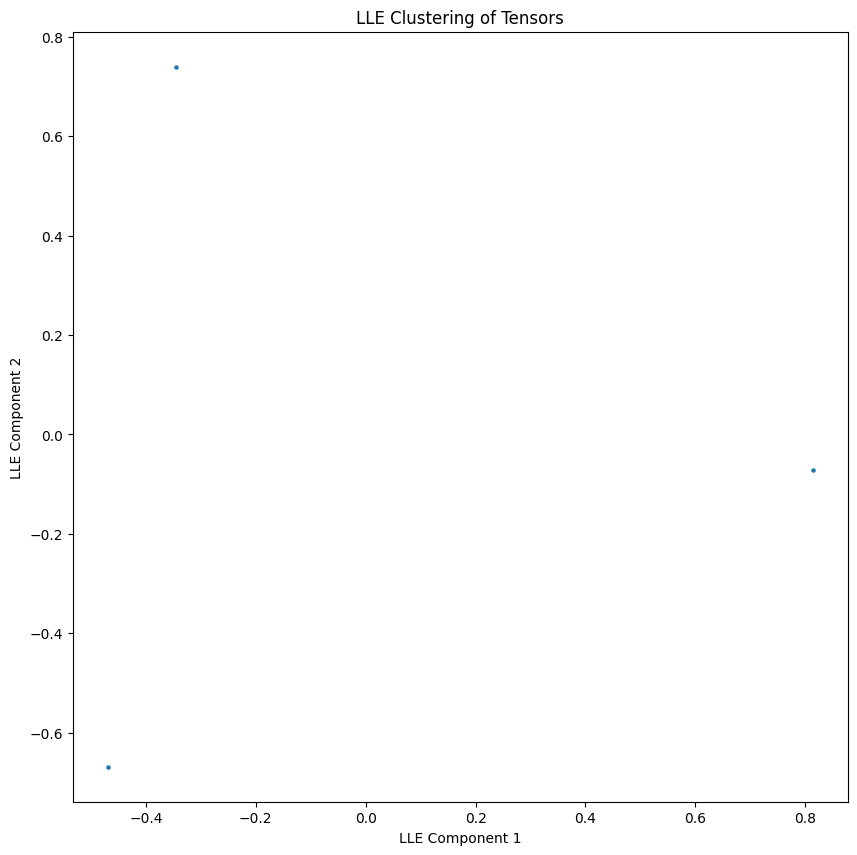

In [5]:
import torch
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt
from typing import List


def flatten_and_concatenate_tensors(tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Flatten each tensor in the list to 1D, and then stack them into a 2D tensor.

    Args:
        tensors (List[torch.Tensor]): A list of tensors of any shape.

    Returns:
        torch.Tensor: A 2D tensor with each row representing a flattened tensor.
    """
    flattened_tensors = [t.flatten() for t in tensors]
    concatenated_data = torch.stack(flattened_tensors)
    return concatenated_data


def visualize_tensor_lle(tensors: List[torch.Tensor], n_components: int = 2, n_neighbors: int = None) -> None:
    """
    Visualize the clustering of tensors using Locally Linear Embedding (LLE).

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_components (int): The number of dimensions for LLE to reduce the data to. Default is 2.
        n_neighbors (int): The number of neighbors to consider for each point in LLE.
                            If None, it will be set to min(number of samples - 1, 5). Default is None.

    Returns:
        None
    """
    # Flatten and concatenate the tensors into a single tensor
    data = flatten_and_concatenate_tensors(tensors)

    # Set the number of neighbors to the minimum of the number of samples minus one, or 5
    if n_neighbors is None:
        n_neighbors = min(data.size(0) - 1, 5)

    # Perform LLE dimensionality reduction
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    lle_data = lle.fit_transform(data.numpy())

    # Plot the LLE embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(lle_data[:, 0], lle_data[:, 1], s=5)
    plt.title("LLE Clustering of Tensors")
    plt.xlabel("LLE Component 1")
    plt.ylabel("LLE Component 2")
    plt.show()


# Example usage with the modified function for LLE visualization
tensor1 = torch.randn(10, 5)
tensor2 = torch.randn(10, 5)
tensor3 = torch.randn(10, 5)

tensor_list = [tensor1, tensor2, tensor3]
visualize_tensor_lle(tensor_list)


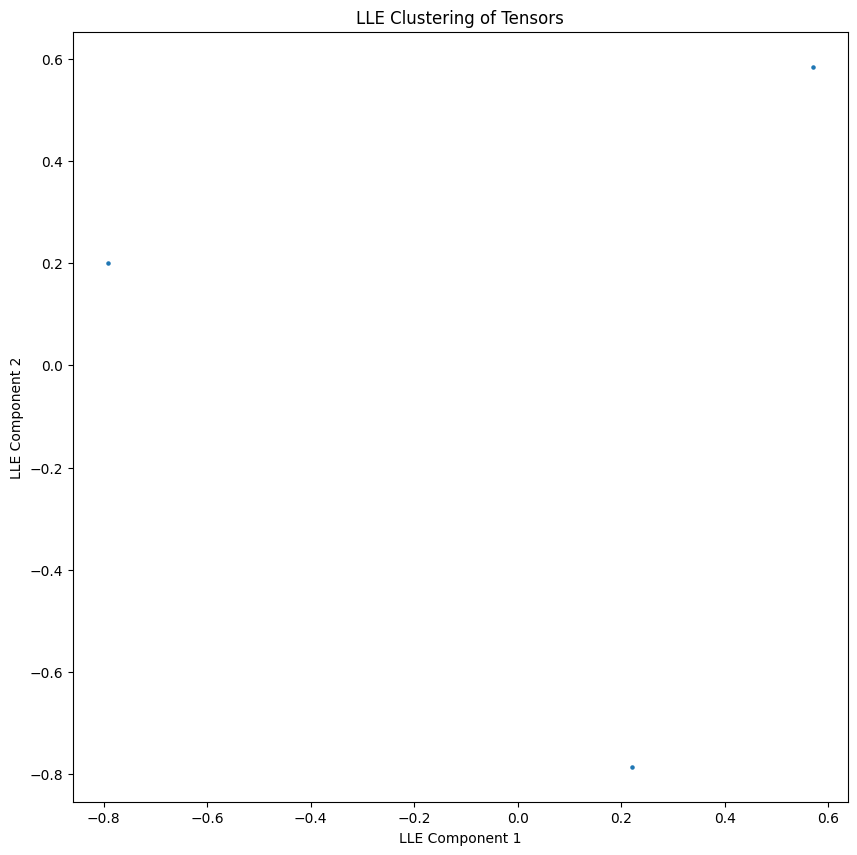

In [6]:
import torch
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt
from typing import List


def flatten_and_concatenate_tensors(tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Flatten each tensor in the list to 1D, and then stack them into a 2D tensor.

    Args:
        tensors (List[torch.Tensor]): A list of tensors of any shape.

    Returns:
        torch.Tensor: A 2D tensor with each row representing a flattened tensor.
    """
    flattened_tensors = [t.flatten() for t in tensors]
    concatenated_data = torch.stack(flattened_tensors)
    return concatenated_data


def visualize_tensor_lle(tensors: List[torch.Tensor], n_components: int = 2, n_neighbors: int = None) -> None:
    """
    Visualize the clustering of tensors using Locally Linear Embedding (LLE).

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_components (int): The number of dimensions for LLE to reduce the data to. Default is 2.
        n_neighbors (int): The number of neighbors to consider for each point in LLE. If None, it will be set to min(5, n_samples - 1). Default is None.

    Returns:
        None
    """
    # Flatten and concatenate the tensors into a single tensor
    data = flatten_and_concatenate_tensors(tensors)

    # Set the number of neighbors based on the number of input tensors
    if n_neighbors is None:
        n_neighbors = min(5, len(tensors) - 1)

    # Perform LLE dimensionality reduction
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    lle_data = lle.fit_transform(data.numpy())

    # Plot the LLE embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(lle_data[:, 0], lle_data[:, 1], s=5)
    plt.title("LLE Clustering of Tensors")
    plt.xlabel("LLE Component 1")
    plt.ylabel("LLE Component 2")
    plt.show()


# Example usage with the modified function for LLE visualization
tensor1 = torch.randn(10, 5)
tensor2 = torch.randn(10, 5)
tensor3 = torch.randn(10, 5)

tensor_list = [tensor1, tensor2, tensor3]
visualize_tensor_lle(tensor_list)


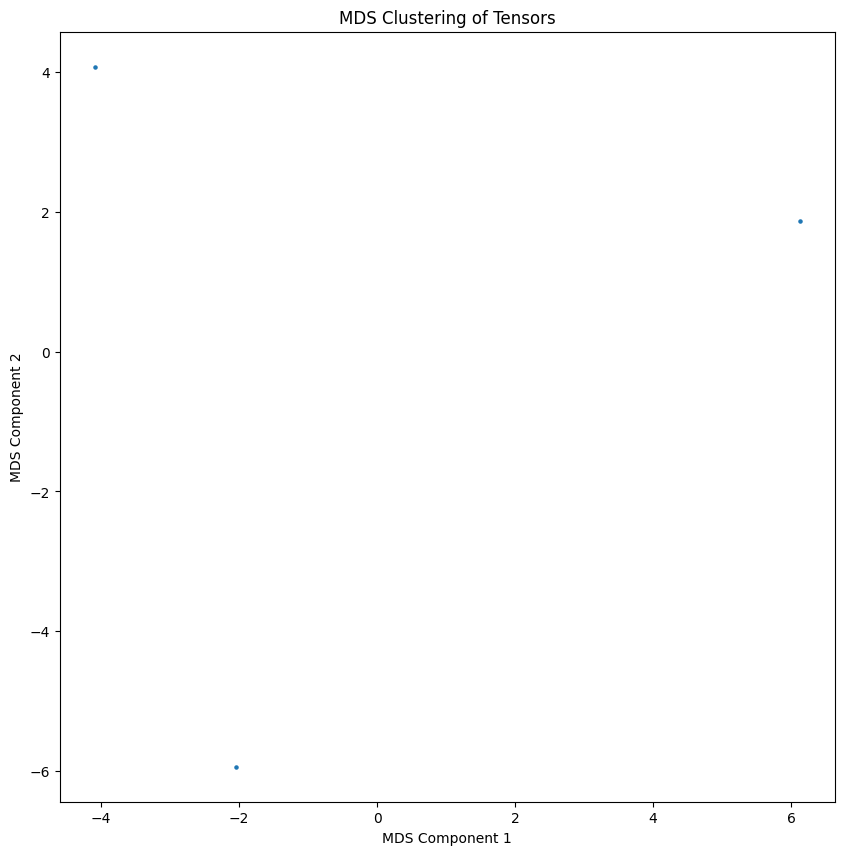

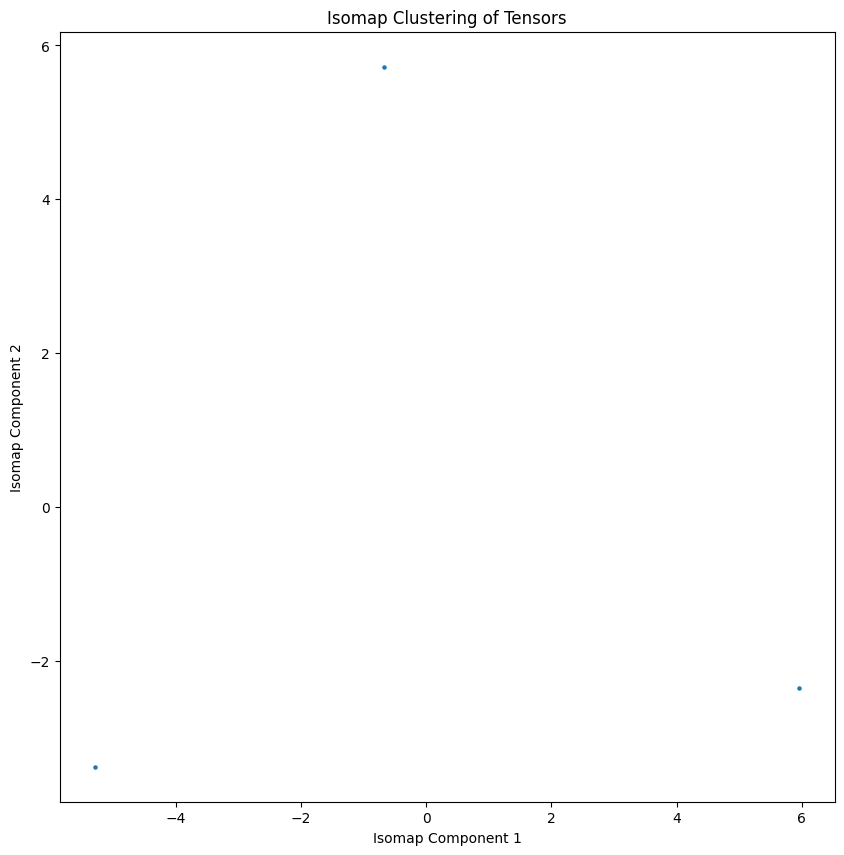

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, Isomap, SpectralEmbedding
from typing import List


def flatten_and_concatenate_tensors(tensors: List[torch.Tensor]) -> torch.Tensor:
    """
    Flatten each tensor in the list to 1D, and then stack them into a 2D tensor.

    Args:
        tensors (List[torch.Tensor]): A list of tensors of any shape.

    Returns:
        torch.Tensor: A 2D tensor with each row representing a flattened tensor.
    """
    flattened_tensors = [t.flatten() for t in tensors]
    concatenated_data = torch.stack(flattened_tensors)
    return concatenated_data


def visualize_tensor_mds(tensors: List[torch.Tensor], n_components: int = 2) -> None:
    """
    Visualize the clustering of tensors using Multi-Dimensional Scaling (MDS).

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_components (int): The number of dimensions for MDS to reduce the data to. Default is 2.

    Returns:
        None
    """
    data = flatten_and_concatenate_tensors(tensors)
    mds = MDS(n_components=n_components)
    mds_data = mds.fit_transform(data.numpy())

    plt.figure(figsize=(10, 10))
    plt.scatter(mds_data[:, 0], mds_data[:, 1], s=5)
    plt.title("MDS Clustering of Tensors")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.show()

# ...

def visualize_tensor_isomap(tensors: List[torch.Tensor], n_components: int = 2, n_neighbors: int = None) -> None:
    """
    Visualize the clustering of tensors using Isomap.

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_components (int): The number of dimensions for Isomap to reduce the data to. Default is 2.
        n_neighbors (int): The number of neighbors to consider for each point in Isomap.
                           If None, it will be set to min(number of samples - 1, 5). Default is None.

    Returns:
        None
    """
    data = flatten_and_concatenate_tensors(tensors)
    if n_neighbors is None:
        n_neighbors = min(data.size(0) - 1, 5)  # Ensure n_neighbors is less than the number of samples

    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    isomap_data = isomap.fit_transform(data.numpy())

    plt.figure(figsize=(10, 10))
    plt.scatter(isomap_data[:, 0], isomap_data[:, 1], s=5)
    plt.title("Isomap Clustering of Tensors")
    plt.xlabel("Isomap Component 1")
    plt.ylabel("Isomap Component 2")
    plt.show()

def visualize_tensor_laplacian_eigenmaps(tensors: List[torch.Tensor], n_components: int = 2, n_neighbors: int = None) -> None:
    """
    Visualize the clustering of tensors using Laplacian Eigenmaps.

    Args:
        tensors (List[torch.Tensor]): A list of tensors to be clustered.
        n_components (int): The number of dimensions for Laplacian Eigenmaps to reduce the data to.
                            Default is 2, but must be less than the number of tensors.
        n_neighbors (int): The number of neighbors to consider for each point in Laplacian Eigenmaps.

    Returns:
        None
    """
    data = flatten_and_concatenate_tensors(tensors)
    n_samples = data.size(0)

    if n_neighbors is None:
        n_neighbors = min(n_samples - 1, 5)  # Ensure n_neighbors is less than the number of samples

    if n_components is None or n_components >= n_samples:
        raise ValueError(f"The number of components (n_components={n_components}) must be less than the number of samples (n_samples={n_samples}).")

    laplacian_eigenmaps = SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    laplacian_eigenmaps_data = laplacian_eigenmaps.fit_transform(data.numpy())

    plt.figure(figsize=(10, 10))
    plt.scatter(laplacian_eigenmaps_data[:, 0], laplacian_eigenmaps_data[:, 1], s=5)
    plt.title("Laplacian Eigenmaps Clustering of Tensors")
    plt.xlabel("Laplacian Eigenmap Component 1")
    plt.ylabel("Laplacian Eigenmap Component 2")
    plt.show()

# No need to pass n_components, default is used


# Example usage
tensor1 = torch.randn(5, 4, 3)
tensor2 = torch.randn(5, 4, 3)
tensor3 = torch.randn(5, 4, 3)

tensor_list = [tensor1, tensor2, tensor3]

# Visualize using MDS (does not require n_neighbors parameter)
visualize_tensor_mds(tensor_list)

# Visualize using Isomap
visualize_tensor_isomap(tensor_list)

# Visualize using Laplacian Eigenmaps
# visualize_tensor_laplacian_eigenmaps(tensor_list)


In [14]:
!pip install -q -U statsmodels



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


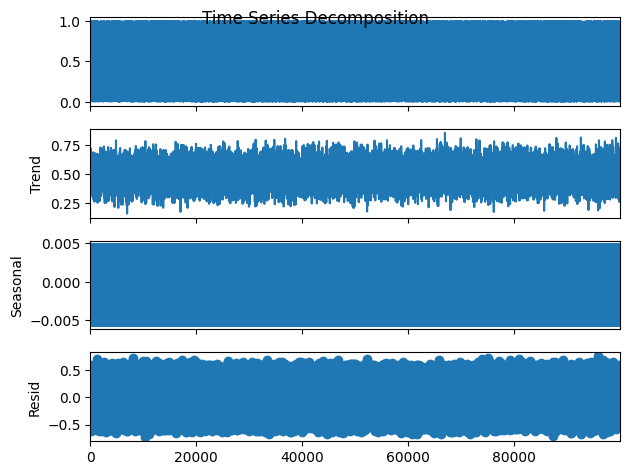

<Figure size 640x480 with 0 Axes>

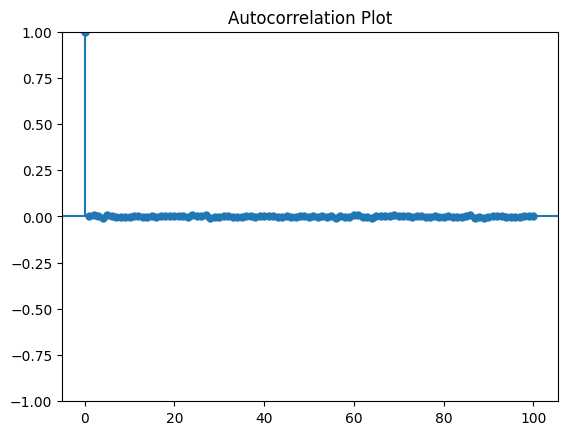

<Figure size 640x480 with 0 Axes>

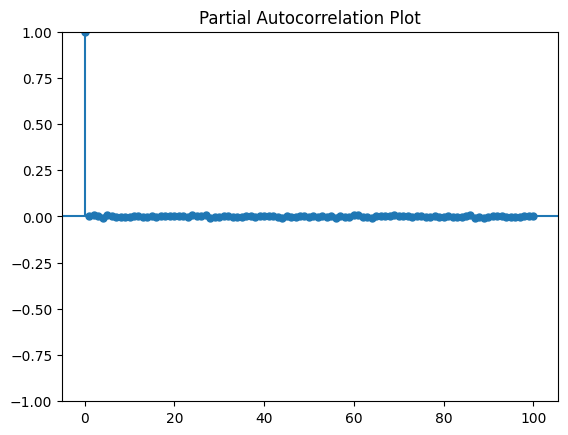

In [15]:
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import andrews_curves
import pandas as pd
from typing import Optional

def visualize_time_series(tensor: torch.LongTensor, frequency: Optional[int] = None) -> None:
    """
    Visualize a time series given a Long tensor.

    Parameters:
    tensor (torch.LongTensor): A Long tensor representing the time series data.
    frequency (Optional[int]): The frequency of the time series, required for decomposition.
    
    Returns:
    None
    """
    # Ensure the tensor is one-dimensional for time series analysis.
    if tensor.ndim != 1:
        raise ValueError("The tensor must be one-dimensional for time series analysis.")
    
    # Convert tensor to NumPy array for compatibility with statsmodels and pandas.
    time_series = tensor.numpy()

    # Convert to pandas Series, assuming the time series is indexed by time.
    time_series = pd.Series(time_series)

    # Time Series Decomposition Plot
    if frequency is not None:
        decomposition = seasonal_decompose(time_series, period=frequency, model='additive')
        decomposition.plot()
        plt.suptitle('Time Series Decomposition')
        plt.show()
    else:
        print("Frequency is not provided, skipping decomposition plot.")

    # Autocorrelation Plot (ACF Plot)
    plt.figure()
    plot_acf(time_series, lags=100)
    plt.title('Autocorrelation Plot')
    plt.show()

    # Partial Autocorrelation Plot (PACF Plot)
    plt.figure()
    plot_pacf(time_series, lags=100)
    plt.title('Partial Autocorrelation Plot')
    plt.show()

    # Andrews Plot (requires DataFrame format with at least one feature and one instance)
    # We'll create a dummy DataFrame to facilitate the Andrews plot.
    # if len(time_series) > 0:
    #     df = pd.DataFrame(time_series, columns=['value'])
    #     plt.figure()
    #     andrews_curves(df, 'value')
    #     plt.title('Andrews Plot')
    #     plt.show()
    # else:
    #     print("Time series is empty, skipping Andrews plot.")
# Example usage
# Assuming 'long_tensor' is a PyTorch LongTensor representing a one-dimensional time series.
# Replace 'long_tensor' and 'frequency_value' with the actual tensor and frequency.
# frequency_value is an integer that represents the seasonality of the time series.
long_tensor =torch.rand(100000)  # Replace with actual data
visualize_time_series(long_tensor, frequency=10)


In [17]:
!pip install -q -U seaborn



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


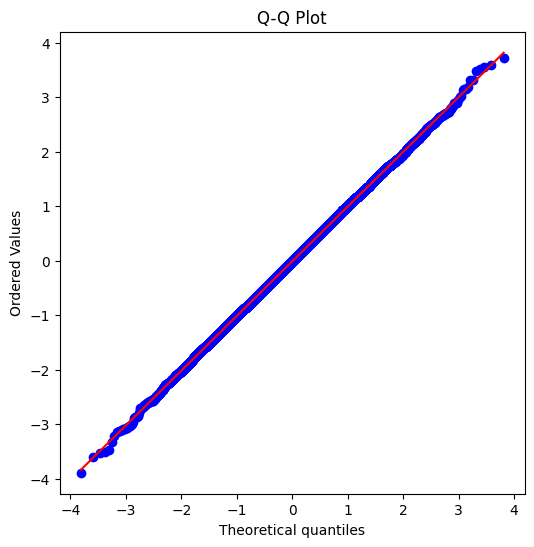

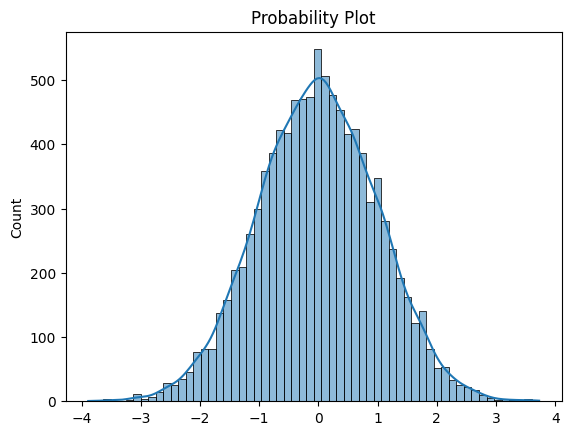

In [19]:
import numpy as np
import torch
from typing import Union
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def convert_tensor_to_numpy(tensor: Union[torch.Tensor, np.ndarray]) -> np.ndarray:
    """Converts a PyTorch Tensor to a NumPy array."""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()  # Ensure tensor is detached and on CPU
    return tensor

def qq_plot(data: np.ndarray) -> None:
    """Generates a Q-Q Plot for the given data."""
    plt.figure(figsize=(6, 6))
    stats.probplot(data.flatten(), dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

def probability_plot(data: np.ndarray) -> None:
    """Generates a Probability Plot for the given data."""
    sns.histplot(data.flatten(), kde=True)
    plt.title('Probability Plot')
    plt.show()

def visualize_tensor(tensor: Union[torch.Tensor, np.ndarray]) -> None:
    """Visualize a tensor using various statistical plots."""
    # Convert tensor to NumPy array if necessary
    data = convert_tensor_to_numpy(tensor)

    # Generate Q-Q Plot
    qq_plot(data)

    # Generate Probability Plot
    probability_plot(data)

# Example usage:
long_tensor = torch.randn(100,100)  # Example Long tensor with random data
visualize_tensor(long_tensor)
